# Final Project: Machine Learning Applications
# *Goodreads meets NLP*
## Bachelor in Data Science and Engineering

<div>
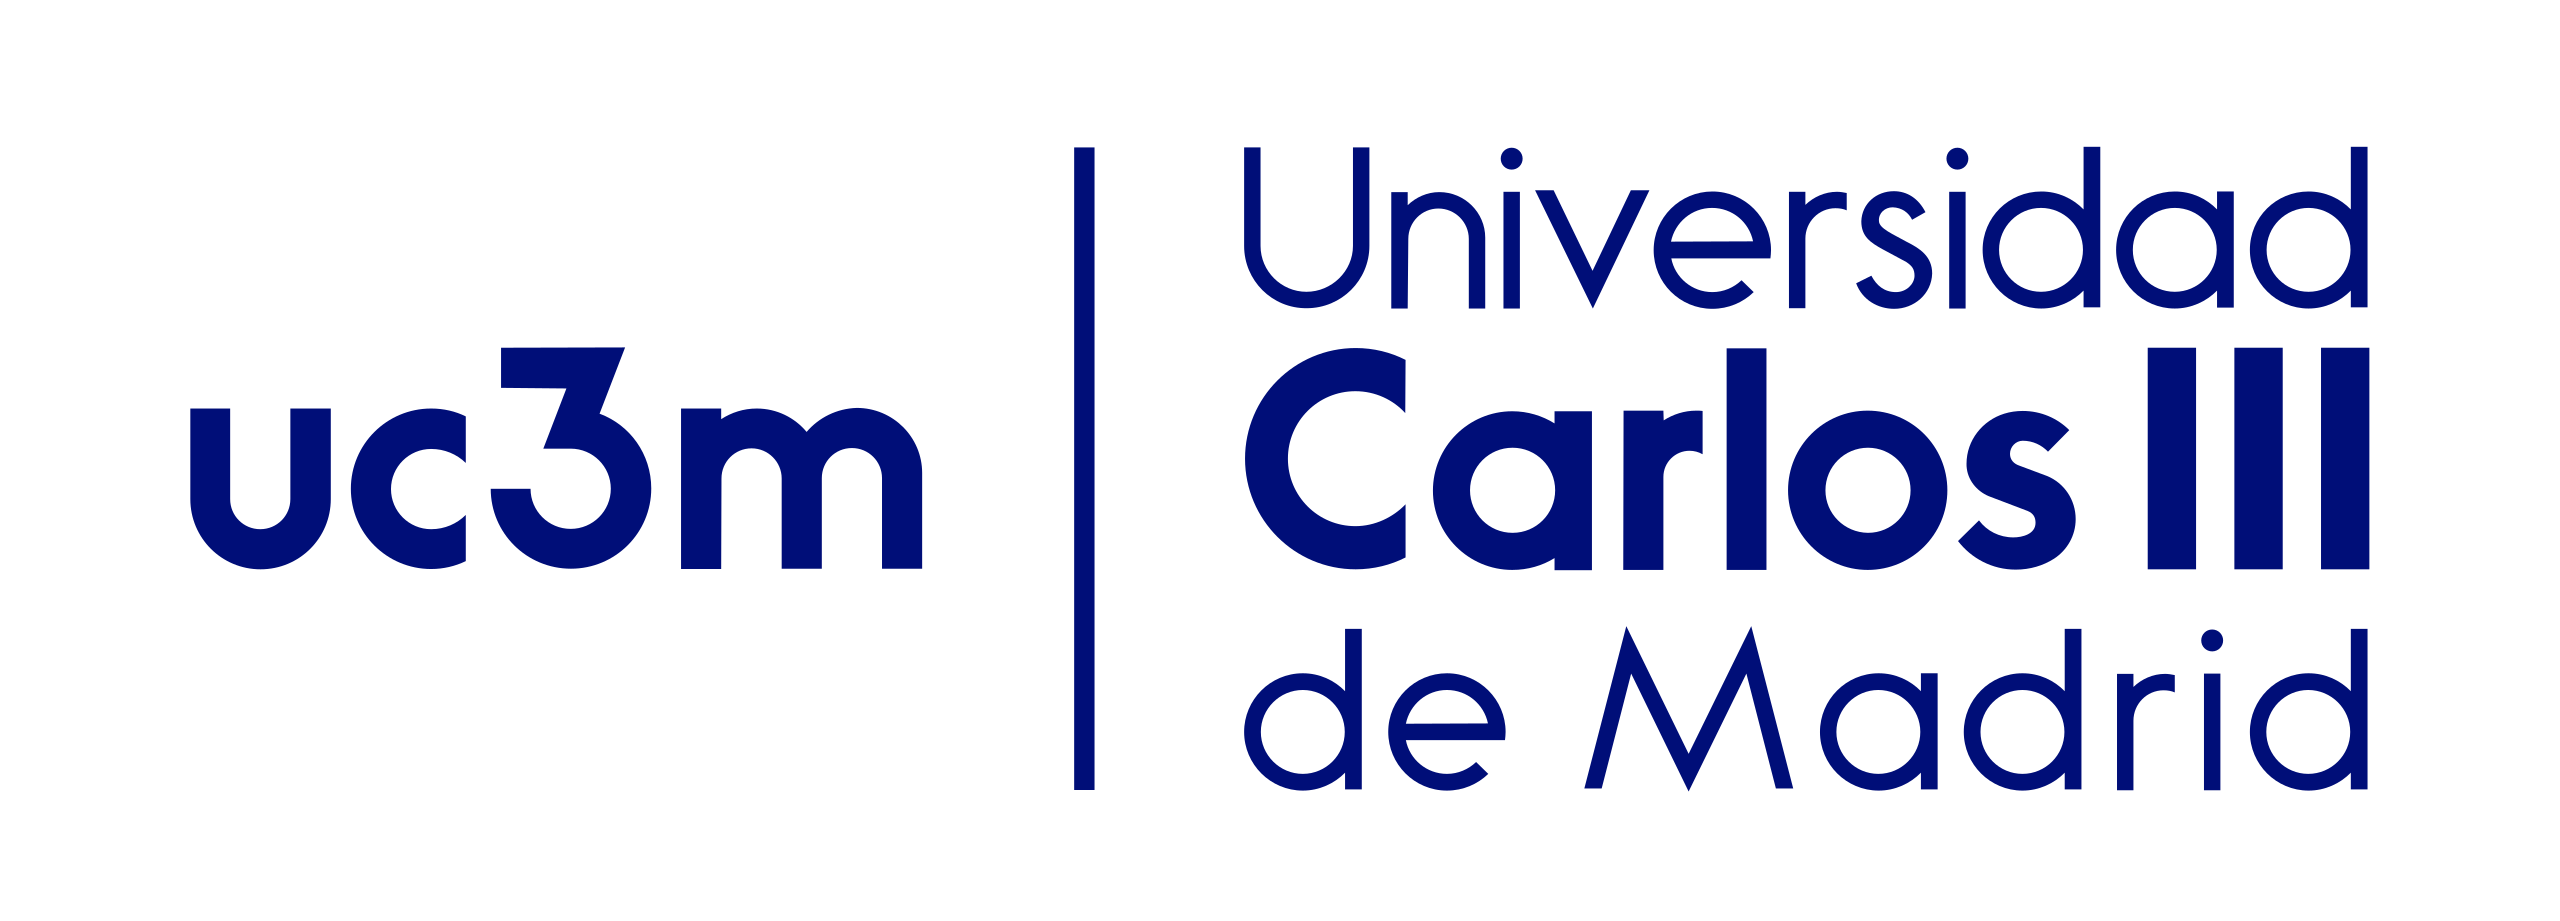
</div>

Done by:

* Alvaro Viejo Alonso (NIA: 100451677)
* Rodrigo Oliver Coimbra (NIA: 100451788)
* Héctor Tienda Cárdenas (NIA: 100)

## 0. Introduction and explanation

In this project we put in practice what was learned in the course of Machine Learning Applications on the area of Natural Language Processing (NLP). We will be analyzing a Goodreads book review dataset and we will be solving two learning tasks: regression (to predict the review score from the review text) and topic modelling (to predict the genre of the book that is being reviewed).

## 1. Data loading and preprocessing pipeline

### 1.1 Data loading

We are loading the `reviews_spoiler_reduced.csv` dataset which consists of three columns: `review_text` (string), `rating` (integer) and `book_genre` (factor).

We will be using `Dask` to apply the tokenization and lemmatization with spaCy of the dataset. This library parallelizes common Python libraries such as `Pandas` or `Numpy` and allows for better scalability, for more information check their [FAQ](https://docs.dask.org/en/stable/faq.html). According to `Dask`'s official webpage: "Dask is used within the world’s largest banks, national labs, retailers, technology companies, and government agencies".

In [1]:
%%time
# !conda install -c conda-forge spacy
# !conda install -c conda-forge cupy`
# !python -m spacy download en_core_web_trf

###### DATA STORAGE & MANIPULATION ######
import pandas as pd
import dask.dataframe as dd
import dask.bag as db
import dask.config
import numpy as np
import csv

###### DATA VISUALIZATION ######
import matplotlib.pyplot as plt
import seaborn as sns

###### NLP ######
import spacy
import gensim

###### OTHERS ######
from tqdm.auto import tqdm

# Create Pandas method to provide tqdm progress
tqdm.pandas()

CPU times: user 9.34 s, sys: 4.92 s, total: 14.3 s
Wall time: 2min 16s


In [2]:
%%time
# Load the sample dataset
sample_dd = dd.read_csv("reviews_spoiler_reduced.csv", encoding="utf-8", usecols=lambda c: c != 'Unnamed: 0')
sample_dd.persist()

CPU times: user 271 ms, sys: 65.3 ms, total: 337 ms
Wall time: 1.79 s


,review_text,rating,book_genre
npartitions=1,,,
,object,int64,object
,...,...,...


In [3]:
# Print the sample dataset
sample_dd.head()

,review_text,rating,book_genre
0,"I originally gave this three stars, but it was...",4,children
1,"they didnt actually quit, they just wrote lett...",4,children
2,This story follows a family consisting of a fa...,5,children
3,"I don't remember reading this book in school, ...",4,children
4,Read for the 2016 YA/MG Book Battle. This book...,5,children


We load `spaCy`'s `en_core_web_trf` model which is optimized for GPU (CUDA) usage and it is larger and slower but its provide more accuracy. `spaCy` is a state-of-the-art open-source library for Natural Language Processing (NLP) that is held in high regard by practicioners all around the world.

The spaCy library provides a trained model with several components that share the `tok2vec`component.



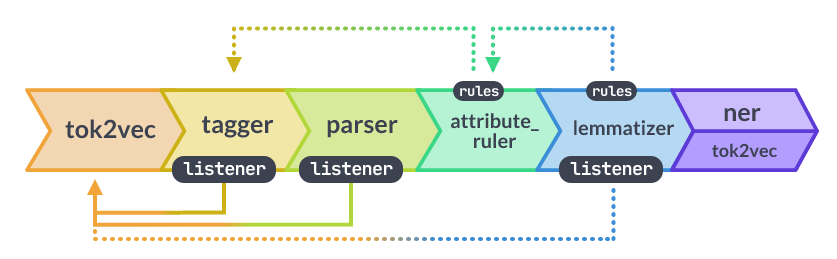

The first `tok2vec` attribute corresponds is this case tou our `transformer`, and it will be responsible for tokenizing the book reviews. 

Then we have the `tagger`which assings the POS (part-of-speech) tags to each word, followed by the `parser`that is tasked with assigning dependency labels. These are very important for spaCy's internal mechanisms and this analysis is further extended by `attribute_ruler` which contains specific rules for each language.

Finally we have the `lemmatizer` which draws from `attribute_ruler` to homogenize the text corpus by reducing the number of word variants (i.e. assigns base forms).

The `ner` (Named Entity Recognizer) is devoted to detecting and labelling named entities that have a specific meaning such as `Tencent` (corporation), `John` (person), `spaniards` (group of people) or `UN` (organization).

In [4]:
%%time
# Load the en_core_web_trf model
nlp = spacy.load("en_core_web_trf")

CPU times: user 3.29 s, sys: 2.2 s, total: 5.49 s
Wall time: 17.8 s


In [5]:
# Print spaCy's nlp pipe parts
print(nlp.pipe_names)

['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


### 1.2 Preprocessing

#### 1.2.1 Tokenization, homogenization, cleaning

In this subsection we will be performing tokenization, homegenization and cleaning using the SpaCy Python library. The `preprocess_text` function is that with the tokenization and lemmatization of all the book reviews and the removel of any stopwords (very common words), punctuation marks and whitespaces. All words are also converted to lowercase for uniformity.

SpaCy was used as it provides state-of-the-art tools in NLP and allows for a streamlined, yet powerful approach to data preprocessing.

In [6]:
def preprocess_text(text, model):
    """
    This function is tasked with tokenizing and lemmatizing the text while
    also removing stopwords, punctuation and whitespaces.
    It returns the remaining token as a string.
    """
    doc = model(text)
    tokens = [
                token.lemma_.lower().strip() \
                    for token in doc \
                        if token.is_alpha \
                        and not token.is_stop \
                        and not token.is_punct \
                        and not token.is_space
    ]
    return tokens

In [7]:
%%time
# Create a new column in the dataset to store the new, cleaned reviews
# for this we will be using Dask's apply function that parallelizes this
# process providing a boost in computation speed
sample_dd["doc"] = sample_dd["review_text"].apply(lambda x: preprocess_text(x, nlp), meta=("text", "str"))

CPU times: user 8.71 s, sys: 2.34 s, total: 11.1 s
Wall time: 11.1 s


In [8]:
%%time
# Save the tokenized and lemmatized dataset
sample_dd.to_csv("reviews_spoiler_reduced_tokenized-*.csv")

CPU times: user 20min 46s, sys: 13.1 s, total: 20min 59s
Wall time: 3min 37s


['/home/leibniz/Documents/UC3M/Machine Learning Applications/Final Project/reviews_spoiler_reduced_tokenized-0.csv']

In [40]:
import os
os.system('notify-send "Execution finished." "Cell execution has finished."')

0

In [42]:
%%time
# Obtain the Pandas Dataframe
sample_df = sample_dd.compute(scheduler="threads", num_workers=os.cpu_count()*2)

CPU times: user 19min 2s, sys: 15.2 s, total: 19min 17s
Wall time: 3min 59s


In [43]:
# Print the transformed Pandas dataframe
sample_df

,review_text,rating,book_genre,doc
0,"I originally gave this three stars, but it was...",4,children,"[originally, give, star, close, decide, miserl..."
1,"they didnt actually quit, they just wrote lett...",4,children,"[nt, actually, quit, write, letter, complaint,..."
2,This story follows a family consisting of a fa...,5,children,"[story, follow, family, consist, father, mothe..."
3,"I don't remember reading this book in school, ...",4,children,"[remember, read, book, school, decide, try, lo..."
4,Read for the 2016 YA/MG Book Battle. This book...,5,children,"[read, ya, mg, book, battle, book, simply, cha..."
...,...,...,...,...
443,Seriously dunno what to think.. This was my re...,3,young_adult,"[seriously, dunno, think, reaction, novel, con..."
444,"Possible trigger warnings: abuse*, teen pregna...",5,young_adult,"[possible, trigger, warning, abuse, teen, preg..."
445,"I really loved this! ""To all the boys I've lov...",5,young_adult,"[love, boy, love, unique, diverse, novel, wond..."
446,"I wanted to give this book three stars, and I ...",4,young_adult,"[want, book, star, think, half, quarter, book,..."


## 2. Text vectorization

In the text vectorization part we will be analyzing the following vectorization schemes:

- Bag-of-Words vs. TF-IDF representation
- Word2vec/FastText vs. Doc2Vec
- Theme extraction and vector representation using LDA.

In this part we will be using Gensim.

### 2.1 Gensim Corpus and N-grams detection

#### 2.1.1 Gensim Corpus

In [44]:
%%time
sample_corpus = sample_df["doc"].tolist()

# To avoid errors with Phraser
#sample_corpus = [str(el) for el in sample_corpus]

CPU times: user 270 µs, sys: 4 µs, total: 274 µs
Wall time: 301 µs


In [45]:
print(f"Number of documents in corpus: {len(sample_corpus)}")
print(f"First review text: \n {sample_corpus[0]}")

Number of documents in corpus: 448
First review text: 
 ['originally', 'give', 'star', 'close', 'decide', 'miserly', 'bump', 'kid', 'kid', 'mean', 'young', 'middling', 'teenager', 'maybe', 'advanced', 'pre', 'teen', 'like', 'read', 'scary', 'story', 'outer', 'limits', 'twilight', 'zone', 'kind', 'feel', 'apparently', 'mean', 'middle', 'grade', 'book', 'storytelling', 'style', 'like', 'element', 'bit', 'gruesome', 'thing', 'particular', 'detail', 'end', 'spoiler', 'tag', 'scare', 'point', 'threshold', 'scare', 'thing', 'kind', 'low', 'scared', 'see', 'blair', 'witch', 'project', 'assure', 'total', 'wimp', 'scare', 'thematically', 'friendship', 'conform', 'ideal', 'normalcy', 'perfection', 'temptation', 'try', 'change', 'people', 'feel', 'like', 'story', 'element', 'manipulate', 'maximum', 'deftness', 'handle', 'reasonably', 'like', 'visual', 'design', 'book', 'endpaper', 'pattern', 'creepy', 'bug', 'text', 'drawing', 'small', 'bug', 'appear', 'margin', 'thing', 'gross', 'see', 'come', '

<Axes: ylabel='Count'>

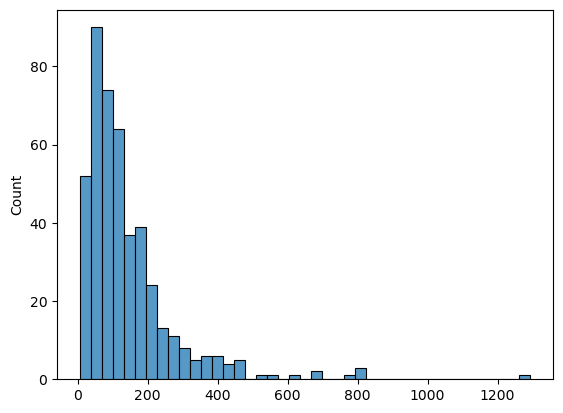

In [46]:
sns.histplot(data=sample_corpus, x=[len(doc) for doc in sample_corpus])

#### 2.1.2 N-grams

More broadly, an *n*-gram is a contiguous sequence of *n* terms from text sample. The *n* prefix denotes the size of the sequence. This notion is specially useful to encapsulate words that have a specific meaning when put together, e.g., *United Kingdom* or *Machine Learning*.

By using `gensim.models.phrases.Phrases` we are able to construct these *n*-grams (we are interested in finding *bigrams* and larger) that meet a certain statistical criteria.

In [47]:
%%time
phrase_model = gensim.models.phrases.Phrases(sample_corpus, min_count=2, threshold=30)
sample_corpus = [el for el in phrase_model[sample_corpus]]

sample_df["doc"] = sample_corpus

CPU times: user 121 ms, sys: 13.8 ms, total: 135 ms
Wall time: 117 ms


In [48]:
%%time
# Save the tokenized and lemmatized dataset with N-grams
sample_df.to_csv("reviews_spoiler_reduced_n_grams-*.csv")

CPU times: user 26.9 ms, sys: 2.98 ms, total: 29.9 ms
Wall time: 32.3 ms


### 2.2 Gensim dictionary

#### 2.2.1 Dictionary creation

Gensim's `Dictionary` is tasked with storing the mappings between the normalized words and their IDs, which are integer values.

In [49]:
%%time
# Create dictionary of tokens
D = gensim.corpora.Dictionary(sample_corpus)
n_tokens = len(D)

CPU times: user 50.6 ms, sys: 984 µs, total: 51.5 ms
Wall time: 51.1 ms


In [50]:
print(f"The postive dictionary contains {n_tokens} terms.")

The postive dictionary contains 9442 terms.


In [51]:
print(f"The first twenty terms in the dictionary are:\
\n{[D[i] for i in range(20)]}")

The first twenty terms in the dictionary are:
['advanced', 'apparently', 'appear', 'assure', 'author', 'bit', 'blair', 'book', 'bug', 'bump', 'cannibalism', 'change', 'close', 'come', 'confirm', 'conform', 'conformer', 'couple', 'creepy', 'decide']


`Dictionary` has many useful attributes such as:

* `token2id | dtype=dict(int,int)`: responsible for the reverse mapping `token` -> `token_id`;
* `cfs | dtype=dict(int,int)`: responsible for mapping `token_id` -> `sum([sum(token) for token in document if token == token_id])`
* `dfs | dtype=dict(int,int)`: responsible for mapping `token_id` -> `sum([1 for document in collection for token_i in document if token_i == token_id])`

We now proceed to a more exploratory analysis in order to better understand the data. In order to do so we will be performing some modifications to it.

#### 2.2.2 Further cleaning

In [52]:
%%time
# Create a list of tuples with token and token frequency per document
token_ndocs = [(D[token_id], token_freq) for token_id, token_freq in D.dfs.items()]

CPU times: user 19.1 ms, sys: 983 µs, total: 20.1 ms
Wall time: 19.2 ms


In [53]:
%%time
# Create dataframe with two columns from the tuple list
token_df = pd.DataFrame(token_ndocs, columns=["token", "ndocs"])

# Sort dataframe according to column ndocs
token_df = token_df.sort_values(by="ndocs", ascending=False)

CPU times: user 7.93 ms, sys: 16 µs, total: 7.94 ms
Wall time: 7.37 ms


In [54]:
token_df

,token,ndocs
26,book,337
14,like,316
15,read,291
17,story,240
240,character,228
...,...,...
5095,bestseller,1
5092,ambitious,1
5091,stunningly,1
5090,anthony_doerr,1


We can clearly see that there are several tokens that appear exactly in only one document. These tokens are not important for our analysis and may therefore be discarded.

*Did you know?:* In linguistics words that only appear once in a given corpus are called **[hapax legomena](https://en.wikipedia.org/wiki/Hapax_legomenon)** (plural form of the transliteration from the Greek ἅπαξ λεγόμενον).

When referring to two, three or four occurrences we use the forms *dis legomenon*, *tris legomenon*, and *tetrakis legomenon*, respectively (note that the plural form is *legomena*).

In [55]:
# Count the number of tokens that appear exactly once in the entire corpus
n_hapax_legomena = token_df[token_df.ndocs == 1].shape[0]

print(f"Number of hapax legomena: {n_hapax_legomena}")

Number of hapax legomena: 5112


Here we can see that there are several *hapax legomena*. Let's improve this analysis by seeing what is the distribution of tokens with respect to the number of times they appear in the text corpus.

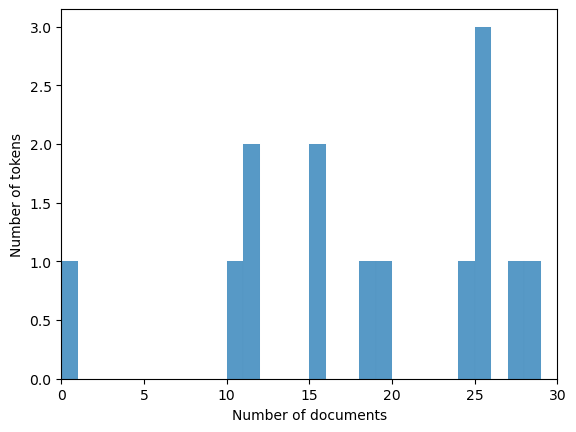

In [56]:
# Store token frequencies in corpus
freq_array = np.zeros(30)
for i in range(30):
    freq_array[i] = token_df[token_df.ndocs == i].shape[0]

# Plot number of words per frequency
sns.histplot(data=freq_array, binwidth=1)
plt.xlabel("Number of documents")
plt.ylabel("Number of tokens")
plt.xlim(0, 30) # Set the x-axis limits
plt.show()


Out of curisioty let's extract the ten most and least common tokens.

In [57]:
# Obtain the most/least common tokens in terms of document occurance
# this could have been easily done with token_df.head(10) 
# and token_df.tail(10)
lm_common_tokens = [
    token_df.iloc[-10:]["token"],
    token_df.iloc[:10]["token"]
]

print(f"The ten most common tokens are:\n{lm_common_tokens[1]}")
print(f"\nThe ten least common tokens are:\n{lm_common_tokens[0]}")


The ten most common tokens are:
26          book
14          like
15          read
17         story
240    character
171        think
265         love
380         good
23          feel
151         know
Name: token, dtype: object

The ten least common tokens are:
5089          acclaim
5105      marie_laure
5104          clarify
5103          catalog
5099      devastation
5095       bestseller
5092        ambitious
5091       stunningly
5090    anthony_doerr
9441      orientation
Name: token, dtype: object


It is known that tokens with very few or very high appeareance frequencies may stymie Natural Processing Language performance. Why? This is because we are unable to extract meaningful patterns across documents using rare words and the converse happens with very common words, they become uninformative as they are present almost anywhere.

There is also the possibility that some of these very strange words are, in fact, just spelling errors.

In order to do this we will be using `Dictionary`method `filter_extremes`which takes two values as input (lower bound, upper bound).

In [58]:
%%time
# Minimum number of documents that store a given token
MIN_APPEARANCES = 4 # tetrakis legomena

# Maximum proportion of documents that store a given token
MAX_FREQUENCY = .85

# Apply the filter_extremes function
D.filter_extremes(no_below=MIN_APPEARANCES, no_above=MAX_FREQUENCY)
n_tokens = len(D)

print(f"The filtered dictionary contains {n_tokens} terms.\n")

The filtered dictionary contains 2155 terms.

CPU times: user 4.88 ms, sys: 1.87 ms, total: 6.75 ms
Wall time: 6.69 ms


We now save the newly filtered data:

In [59]:
corpus_df = []
for sent in sample_corpus:
  corpus_df.append([token for token in sent if token in D.token2id.keys()])

sample_df["clean_doc"] = corpus_df

In [60]:
sample_df

,review_text,rating,book_genre,doc,clean_doc
0,"I originally gave this three stars, but it was...",4,children,"[originally, give_star, close, decide, miserly...","[give_star, close, decide, kid, kid, mean, you..."
1,"they didnt actually quit, they just wrote lett...",4,children,"[nt, actually, quit, write, letter, complaint,...","[nt, actually, write, letter, complaint, tell,..."
2,This story follows a family consisting of a fa...,5,children,"[story, follow, family, consist, father, mothe...","[story, follow, family, consist, father, mothe..."
3,"I don't remember reading this book in school, ...",4,children,"[remember, read, book, school, decide, try, lo...","[remember, read, book, school, decide, try, lo..."
4,Read for the 2016 YA/MG Book Battle. This book...,5,children,"[read, ya, mg, book, battle, book, simply, cha...","[read, ya, book, battle, book, simply, charmin..."
...,...,...,...,...,...
443,Seriously dunno what to think.. This was my re...,3,young_adult,"[seriously, dunno, think, reaction, novel, con...","[seriously, think, reaction, novel, concept, b..."
444,"Possible trigger warnings: abuse*, teen pregna...",5,young_adult,"[possible, trigger_warning, abuse, teen, pregn...","[possible, trigger_warning, abuse, teen, suici..."
445,"I really loved this! ""To all the boys I've lov...",5,young_adult,"[love, boy, love, unique, diverse, novel, wond...","[love, boy, love, unique, diverse, novel, wond..."
446,"I wanted to give this book three stars, and I ...",4,young_adult,"[want, book, star, think, half, quarter, book,...","[want, book, star, think, half, quarter, book,..."


### 2.3 Bag-of-Words (BoW)

**Bag-of-Words (BoW)** is a technique used for text representation simplification in the realm of Natural Language Processing (NLP). The BoW representation consists in storing the number of appearances of each word for each document in the corpus.

The limitations of the BoW representation are clear: it is an extention of the One-Hot Encoding one and it discards grammatical and word order/word position information.

In order to obtain a BoW representation of our corpus we will be using the `doc2bow`provided by Gensim's `Dictionary`. Data is stored in a sparse vector representation with a tuple of `int`s denoting the `token_id` and the other its frequency.

In [61]:
%%time
# Store the BoW representation of all tokens per corpus document
reviews_bow = [D.doc2bow(doc) for doc in corpus_df]

CPU times: user 20.6 ms, sys: 984 µs, total: 21.6 ms
Wall time: 21.5 ms


### 2.4 Term frequency - Inverse document frequency (TF-IDF)

**Term frequency - Inverse document frequency (TF-IDF)** is another technique for text representation simplification for NLP. It takes into account more information and factors than the simpler, BoW transformation.

TF-IDF has the following property: it gives a high value for a term in a given document if that term is common within that document and rare otherwise, i.e., in the rest of the corpus. This means that while BoW is easier to interpret, TF-IDF provides more information about the commnality of certain words and is conditioned by the entire corpus by the IDF.

As expressed previously, TF-IDF is constituted by two different factors: *term frequency* and *inverse document frequency*.

* **Term frequency**: number of time a given word appears in a document.
$$\text{TF}(w, d) = \text{BoW}(w,d)$$

* **Inverse document frequency**: logarithm of the number of documents in the corpus divided by the number of documents with word $w$.
$$\text{IDF}(w) = \text{log}\left(\frac{\#\text{docs}}{\#\text{docs with term } w}\right)$$

So the TF-IDF is given by:
$$\text{TF-IDF} = \text{TF}(w,d) \times \text{IDF}(w)$$

**Note**: Because TF-IDF takes into account the entirety of the corpus in its computations for each element of the document-token matrix is not *not* possible to update it in Gensim's implementation by adding more documents as this would entail a loss of consistency.

In [74]:
%%time
# Build TF-IDF model with Gensim's TfidfModel
tfidf = gensim.models.TfidfModel(reviews_bow)

CPU times: user 14.6 ms, sys: 985 µs, total: 15.5 ms
Wall time: 15.1 ms


We can now use `reviews_tfidf`to convert any vector from the BoW representation into the new one, using TF-IDF.

In [75]:
%%time
reviews_tfidf = tfidf[reviews_bow]

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 77.7 µs
